## Economic Dispatch (ED)
_Power System Optimization_

System operators must select the most cost effective combination of generators, each with distinct cost structures and engineering limitations. ED is a key operational model for the optimization of the variable (short-run) production costs of a fleet of generators, subject to various technical constraints, to meet the total electricity demand. 

- **Characteristics**:
    - Objective: Minimize short-run costs of different producing generators while meeting the total system damand, considering relevant constraints.
    - Constraints: Power balance (total generation = total demand), generation limits (minimum and maximum capacity), and sometimes ramp rates for generators.
    - Assumptions: Assumes the system can adjust generation output in real-time to minimize cost while meeting demand, without considering transmission constraints.Physics of electricity flows and constraints related to turning on or "committing" large thermal generators aswell as network representation are neglected  

- **Advantages**: 
    - Simple and efficient for real-time dispatch decisions.
- **Disadvantages**:
    - Ignores power system constraints like voltage, line flow, and losses.
    - Cannot handle reactive power optimization or voltage stability concerns.

- **Field of Application**:
    - Real-time and short-term dispatch in power markets.
    - Used in situations where the main concern is balancing generation and demand economically without consideration of network constraints.

>[!NOTE]  
>fix costs will not change and would be constant in the objective function -> optimal decision variables would not change by adjusting this constant, therefore, they can safely be ignored for the purposes of finding optimal dispatch, but will have to be considered to calculate producer profits.

### Different complexity levels:  
1. [Single-time period, simple generator constraints](#1-single-time-period-simple-generator-constraints)
2. [Multiple-time period, simple generator constraints](#2-multiple-time-period-simple-generator-constraints)
3. [Multiple-time period, complex generator constraints with time coupling (_including ramp up and ramp down_)](#3-multiple-time-period-complex-generator-constraints-with-time-coupling) 

### 1. Single-time period, simple generator constraints

**Problem Formulation**:  
Determine the power generation by each generator, minimising the power generation cost while meeting the given static system demand and considering (only) the variable OM costs for each generator.

$$G = \text{set of generators}$$

Objective Function:  
$$min \sum_{g \in G} 
VarCost_g \times x_g$$

subject to:
$$\begin{aligned}
    \sum_g x_g & = Demand \\
    x_g &\le P^{max}_g  & \quad  \forall g \in G \\
    x_g &\ge P^{min}_g   & \quad \forall g \in G \\
\end{aligned}$$

Decision Variable:  
$$x_g: \text{generation in MW, produced by each generator g}$$

Parameters:

- $P^{min}_g$, the minimum operating bounds for the generator (based on engineering or natural resource constraints)
- $P^{max}_g$, the maximum operating bounds for the generator (based on engineering or natural resource constraints)
- $Demand$ in MW
- Variable Costs:

$$
VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g
$$
with OM: operating and maintenance.  
For renewables (variable generators) it reduces to $VarCost_g = VarOM_g$

In [604]:
import pandas as pd
df_generators=pd.read_csv('generators.csv', sep=',')
df_generators.fillna(0, inplace=True)

df_variables = df_generators.loc[df_generators.is_variable==1]
df_non_variables = df_generators.loc[df_generators.is_variable!=1]

df_generators

,Resource,Pmax,Pmin,is_variable,CF,VarOM,RampUp,RampDn,FuelCost,HeatRate,Capex
0,Biomass,20,0.7,0,1.0,5,0.2,0.2,1,12.76,1_000_000
1,Wind onshore,700,0.0,1,0.3,0,1.0,1.0,0,0.00,1_000_000
2,Wind offshore,100,0.0,1,0.7,0,1.0,1.0,0,0.00,1_000_000
3,Solar,1000,0.0,1,0.1,0,1.0,1.0,0,0.00,1_000_000
4,Gas_Turbine,1500,0.7,0,1.0,10,0.2,0.2,3,9.10,1_000_000
5,Pumped Storage,40,0.0,0,1.0,0,0.2,0.2,1,0.00,1_000_000
6,Battery,0,0.0,0,1.0,0,1.0,1.0,0,0.00,1_000_000


In [605]:
df_variables

,Resource,Pmax,Pmin,is_variable,CF,VarOM,RampUp,RampDn,FuelCost,HeatRate,Capex
1,Wind onshore,700,0.0,1,0.3,0,1.0,1.0,0,0.0,1_000_000
2,Wind offshore,100,0.0,1,0.7,0,1.0,1.0,0,0.0,1_000_000
3,Solar,1000,0.0,1,0.1,0,1.0,1.0,0,0.0,1_000_000


#### Pyomo Solution
[_Single-time period, simple generator constraints_](#1-single-time-period-simple-generator-constraints)

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: 38.541999999999994
  Upper bound: 38.541999999999994
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Termination message: TerminationCondition.optimal
# ----------------------------------------------------------
#   Solution Information
# -------------------------------------------------------

<Axes: title={'center': 'Pyomo Solution'}, xlabel='#-generator', ylabel='MW'>

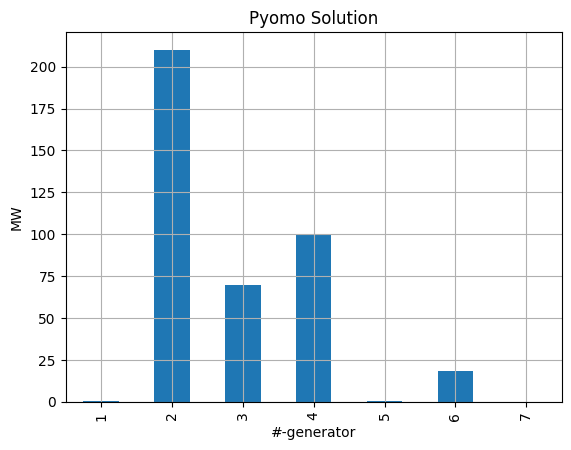

In [606]:
import pyomo.environ as pyo

n_generators = len(df_generators)
const_total_demand = 400

model = pyo.ConcreteModel()

# Sets
model.G = pyo.RangeSet(n_generators)
model.G_var = pyo.Set(initialize=df_variables.index+1)
model.G_non_var = pyo.Set(initialize=df_non_variables.index+1)

# Decision Variable
def bounds_rule(model, g):
    return (df_generators.Pmin[g-1], df_generators.Pmax[g-1])
model.x = pyo.Var(
    model.G, 
    within=pyo.NonNegativeReals, 
    bounds=bounds_rule,
)

# Params are defined for the whole generator set model.G, because, as HeatRate and FuelCost are set to 0, 
# VarCost is automatically reduced to VarOM for variable generators.
model.VarOM = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.VarOM)))
model.HeatRate = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.HeatRate)))
model.FuelCost = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.FuelCost)))
model.CF = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.CF)))
model.Pmax = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.Pmax)))

# Objective 
model.total_costs=pyo.Objective(
    expr=sum(
        model.x[g] * (model.VarOM[g] + model.HeatRate[g] * model.FuelCost[g]) 
        for g in model.G
    ),
    sense=pyo.minimize
)

# Constraints
def demand_rule(model):
    return sum(model.x[g] for g in model.G) == const_total_demand
model.demand_constraint = pyo.Constraint(rule=demand_rule)

# capacity_constraint_non_var not necessary due to bounds rule

def capacity_rule_var(model, g):
    return model.x[g] == model.CF[g] * model.Pmax[g]
model.capacity_constraint_var = pyo.Constraint(model.G_var, rule=capacity_rule_var)

optimizer = pyo.SolverFactory("appsi_highs")
result = optimizer.solve(model)

result.write()
print(f"total costs: {pyo.value(model.total_costs)}")
# model.x.display()
pd.Series(model.x.extract_values()).plot(grid=True, kind="bar", title="Pyomo Solution", xlabel="#-generator", ylabel="MW")


#### Linopy Solution
[_Single-time period, simple generator constraints_](#1-single-time-period-simple-generator-constraints)

In [607]:
import linopy 

model = linopy.Model()

const_total_demand = 400

# Decision Variable
x = model.add_variables(
    lower=df_generators.Pmin, 
    upper=df_generators.Pmax,
    coords=[df_generators.index],
    name="generators"
)

# no direct need to define Parameters and Sets with linopy

# Constraints
demand_constraint = model.add_constraints(x.sum() == const_total_demand)

def var_capacity_rule(model, i):
    return x[i] == df_variables.CF[i] * df_variables.Pmax[i]
capacity_constraint_var = model.add_constraints(var_capacity_rule ,coords=[df_variables.index])

def non_var_capacity_rule(model, i):
    return x[i] <= df_non_variables.Pmax[i]
capacity_constraint_non_var = model.add_constraints(non_var_capacity_rule, coords=[df_non_variables.index])

# Objective
obj = (x * (df_generators.VarOM + df_generators.HeatRate * df_generators.FuelCost)).sum()
model.add_objective(obj, overwrite=True, sense='min')

model.solve()


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1 rows, 2 cols, 2 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-8); columns 0(-7); elements 0(-14) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  3.8542000000e+01
HiGHS run time      :          0.00


('ok', 'optimal')

<Axes: title={'center': 'Linopy Solution'}, xlabel='#-generator', ylabel='MW'>

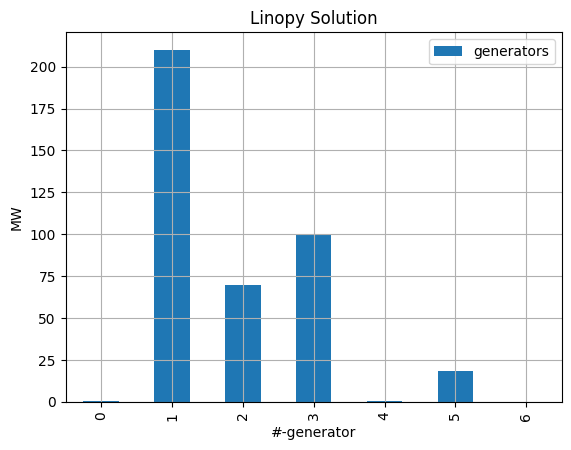

In [608]:
solution = model.solution.to_dataframe()
solution.plot(grid=True, kind="bar", title="Linopy Solution", xlabel="#-generator", ylabel="MW")

### 2. Multiple-time period, simple generator constraints
  
**Problem Formulation**:  
Determine the power generation by each generator, minimising the power generation cost while meeting the given dynamic system demand and considering (only) the variable OM costs for each generator.  
The time dependency of the demand and the generation is to be taken into account.

-> an additional time index t is introduced:
      
      
Objective Function:
$$ \min \sum_{g \in G, t \in T} VarCost_g \times x_{g,t} $$
subject to:
$$\begin{align}
    \sum_{g} x_{g,t} = Demand_t \quad \forall  t \in T \\
    x_{g,t} \leq P^{max}_{g,t} \quad \forall g \in G , t \in T \\
    x_{g,t} \geq P^{min}_{g,t} \quad \forall g \in G , t \in T \\
\end{align}$$
    
- for conventional resources Pmin and Pmax are constant over time
- for variable (renewable) generators, $Pmax_{g,t}$ varies with time (i.e., based on solar irradiation or wind speeds). $Pmin_{g,t}$ for wind and solar resources is usually 0.
- for hydropower resources minimum streamflow constraints can produce a time-variant parameter for $Pmin_{g,t}$.
- each time period is balanced separately without regard to what is happening before.

### Pyomo Solution
[_Multiple-time period, simple generator constraints_](#2-multiple-time-period-simple-generator-constraints)  

In [609]:
import requests
import pandas as pd

url = "https://api.energy-charts.info/total_power"

end = pd.Timestamp.today() -pd.Timedelta(days=1)
start = end - pd.Timedelta(days=2)

params = {
    "country": "de" ,
    "start": round(start.timestamp()), 
    "end": round(end.timestamp()),
}

response = requests.get(url=url, params=params)

response.text

'{"unix_seconds":[1728217800,1728218700,1728219600,1728220500,1728221400,1728222300,1728223200,1728224100,1728225000,1728225900,1728226800,1728227700,1728228600,1728229500,1728230400,1728231300,1728232200,1728233100,1728234000,1728234900,1728235800,1728236700,1728237600,1728238500,1728239400,1728240300,1728241200,1728242100,1728243000,1728243900,1728244800,1728245700,1728246600,1728247500,1728248400,1728249300,1728250200,1728251100,1728252000,1728252900,1728253800,1728254700,1728255600,1728256500,1728257400,1728258300,1728259200,1728260100,1728261000,1728261900,1728262800,1728263700,1728264600,1728265500,1728266400,1728267300,1728268200,1728269100,1728270000,1728270900,1728271800,1728272700,1728273600,1728274500,1728275400,1728276300,1728277200,1728278100,1728279000,1728279900,1728280800,1728281700,1728282600,1728283500,1728284400,1728285300,1728286200,1728287100,1728288000,1728288900,1728289800,1728290700,1728291600,1728292500,1728293400,1728294300,1728295200,1728296100,1728297000,172

In [610]:

data = response.json()
index = data.pop(list(data.keys())[0])  # rely on dict order

df_dyn_generation_energy_charts = pd.DataFrame(
    {item['name']:item['data'] for item in data['production_types']},
    index=pd.DatetimeIndex(pd.to_datetime(index, unit='s'))
)

GW_to_MW = 1000
installed_capacity = pd.read_csv('energy-charts_Installierte_Netto-Leistung_de_2024.csv', index_col='Jahr').T.astype({2024:'float'})
installed_capacity.drop(installed_capacity.columns[0],axis=1, inplace=True)
installed_capacity = installed_capacity *  GW_to_MW 

installed_total_capacity = installed_capacity[2024].sum()


In [611]:
import pyomo.environ as pyo

n_generators = len(df_generators.index)
df_dyn_total_demand = df_dyn_generation_energy_charts["Load (incl. self-consumption)"] / installed_total_capacity * df_generators.Pmax.sum()  # simulate only partial network demand

model = pyo.ConcreteModel()

# Sets
model.G = pyo.RangeSet(n_generators)
model.G_var = pyo.Set(initialize=df_variables.index+1)
model.G_non_var = pyo.Set(initialize=df_non_variables.index+1)
model.T = pyo.RangeSet(len(df_dyn_generation_energy_charts))


# Decision Variable
def bounds_rule(model, g, t):
    return (df_generators.Pmin[g-1], df_generators.Pmax[g-1])
model.x = pyo.Var(
    model.G, 
    model.T,
    within=pyo.NonNegativeReals, 
    bounds=bounds_rule,
)

# Params 

init_CF = {(g, t): 
    df_dyn_generation_energy_charts[df_generators.loc[g-1].Resource].iloc[t-1]/ installed_capacity.loc[df_generators.loc[g-1].Resource, 2024]
    for g in model.G_var 
    for t in model.T
} # simulate time dependent cf factors with real generation/ real installed capacity

model.VarOM = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.VarOM)))
model.HeatRate = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.HeatRate)))
model.FuelCost = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.FuelCost)))
model.CF = pyo.Param(model.G, model.T, initialize=init_CF)
model.Pmax = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.Pmax)))
model.Demand = pyo.Param(model.T, initialize=dict(zip(model.T, df_dyn_total_demand)))  


# Objective 
model.total_costs=pyo.Objective(
    expr=sum(
        model.x[g,t] * (model.VarOM[g] + model.HeatRate[g] * model.FuelCost[g]) 
        for g in model.G for t in model.T
    ),
    sense=pyo.minimize
)

# Constraints
def demand_rule(model, t):
    return sum(model.x[g,t] for g in model.G) == model.Demand[t]
model.demand_constraint = pyo.Constraint(model.T, rule=demand_rule)

# capacity_constraint_non_var not necessary due to bounds rule

def capacity_rule_var(model, g, t):
    return model.x[g, t] == model.CF[g, t] * model.Pmax[g]
model.capacity_constraint_var = pyo.Constraint(model.G_var, model.T, rule=capacity_rule_var)

optimizer = pyo.SolverFactory("appsi_highs")
result = optimizer.solve(model)

result.write()
print(f"total costs: {pyo.value(model.total_costs)}")
# model.x.display()


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: 3368979.2238271153
  Upper bound: 3368979.2238271153
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Termination message: TerminationCondition.optimal
# ----------------------------------------------------------
#   Solution Information
# -------------------------------------------------------

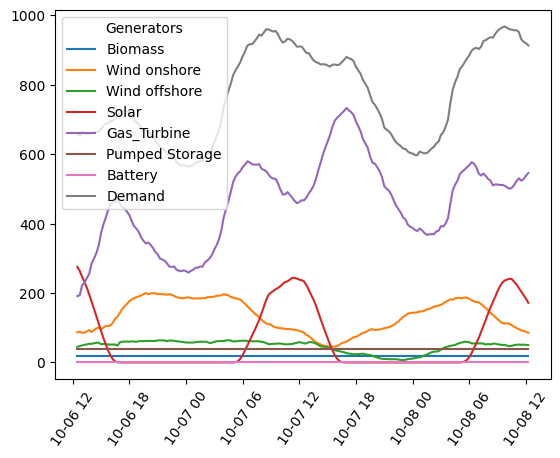

In [612]:
# Visualize optimized power generation 

import matplotlib.pyplot as plt 

data = model.x.extract_values()
index = df_dyn_generation_energy_charts.index

df_data = pd.Series(data).unstack(level=0)
df_data.index = index
df_data.columns=[f"{df_generators.loc[generator-1].Resource}" for generator in df_data.columns]

for generator in df_data.columns:
    plt.plot(df_data[generator], label=generator)
plt.plot(df_dyn_total_demand, label='Demand')

plt.legend(title='Generators')
plt.tick_params(axis='x', rotation=55)
plt.show()


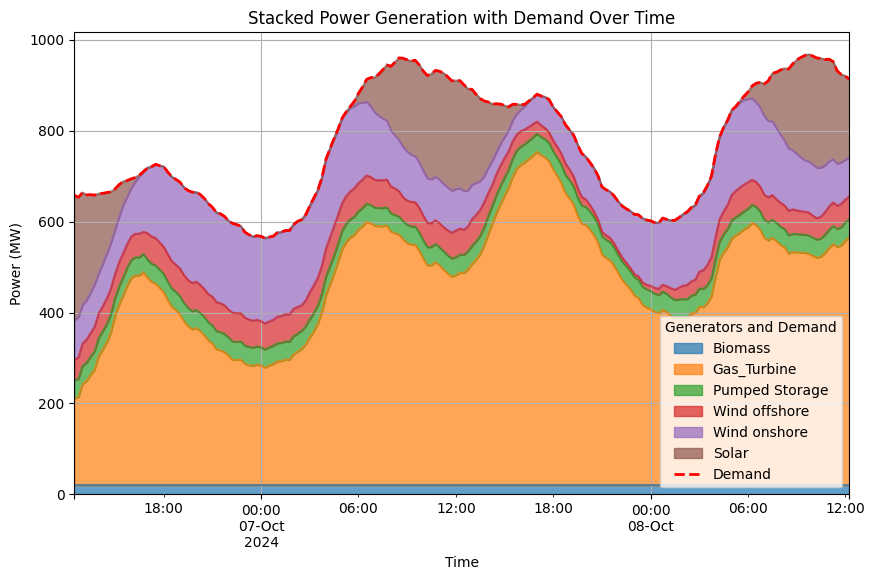

In [613]:
# Visualize stacked optimized power generation
#  
ax = df_data[[ 'Biomass', 'Gas_Turbine', 'Pumped Storage', 'Wind offshore', 'Wind onshore', 'Solar']].plot(kind='area', stacked=True, figsize=(10, 6), alpha = 0.7)
df_dyn_total_demand.plot(ax=ax, label='Demand', linestyle='--',color='red', linewidth=2)

plt.title('Stacked Power Generation with Demand Over Time')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.grid(True)
plt.legend(title='Generators and Demand',loc='lower right')

## 3. Multiple-time period, complex generator constraints with time coupling
   
**Problem Formulation**:  
Determine the power generation by each generator, minimizing the power generation cost while meeting the given dynamic system demand and considering (only) the variable OM costs for each generator.  
The time dependency of the demand and the generation, aswell time coupling, is to be taken into account.
  

-> Time coupling is introduced by ramp rates, which limit the change in the generators output from one time period to the next one:
  
Objective Function:
$$\min \sum_{g \in G, t \in T} VarCost_g \times x_{g,t} $$
subject to:
$$\begin{align}
    \sum_{g} x_{g,t} = Demand_t & \quad \forall t \in T \\
    x_{g,t} \leq Pmax_{g,t} &  \quad \forall g \in G , t \in T \\
    x_{g,t} \geq Pmin_{g,t} &  \quad \forall g \in G , t \in T \\
    x_{g,t+1} - x_{g,t} \leq RampUp_{g} & \quad \forall g \in G , t = 1..T-1 \\
    x_{g,t} - x_{g,t+1} \leq RampDown_{g} &  \quad \forall g \in G , t = 1..T-1
\end{align}$$

In [618]:
import pyomo.environ as pyo

n_generators = len(df_generators.index)
df_dyn_total_demand = df_dyn_generation_energy_charts["Load (incl. self-consumption)"] / installed_total_capacity * df_generators.Pmax.sum()  # simulate only partial network demand

model = pyo.ConcreteModel()

# Sets
model.G = pyo.RangeSet(n_generators)
model.G_var = pyo.Set(initialize=df_variables.index+1)
model.G_non_var = pyo.Set(initialize=df_non_variables.index+1)
model.T = pyo.RangeSet(len(df_dyn_generation_energy_charts))


# Decision Variable
def bounds_rule(model, g, t):
    return (df_generators.Pmin[g-1], df_generators.Pmax[g-1])
model.x = pyo.Var(
    model.G, 
    model.T,
    within=pyo.NonNegativeReals, 
    bounds=bounds_rule,
)

# Params 

init_CF = {(g, t): 
    df_dyn_generation_energy_charts[df_generators.loc[g-1].Resource].iloc[t-1]/ installed_capacity.loc[df_generators.loc[g-1].Resource, 2024]
    for g in model.G_var 
    for t in model.T
} # simulate time dependent cf factors with real generation/ real installed capacity

model.VarOM = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.VarOM)))
model.HeatRate = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.HeatRate)))
model.FuelCost = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.FuelCost)))
model.CF = pyo.Param(model.G, model.T, initialize=init_CF)
model.Pmax = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.Pmax)))
model.Demand = pyo.Param(model.T, initialize=dict(zip(model.T, df_dyn_total_demand)))
model.ramp_up_percentage = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.RampUp)))
model.ramp_dn_percentage = pyo.Param(model.G, initialize=dict(zip(model.G, df_generators.RampDn)))


# Objective 
model.total_costs=pyo.Objective(
    expr=sum(
        model.x[g,t] * (model.VarOM[g] + model.HeatRate[g] * model.FuelCost[g]) 
        for g in model.G for t in model.T
    ),
    sense=pyo.minimize
)

# Constraints
def demand_rule(model, t):
    return sum(model.x[g,t] for g in model.G) == model.Demand[t]
model.demand_constraint = pyo.Constraint(model.T, rule=demand_rule)

# capacity_constraint_non_var not necessary due to bounds rule

def capacity_rule_var(model, g, t):
    return model.x[g, t] == model.CF[g, t] * model.Pmax[g]
model.capacity_constraint_var = pyo.Constraint(model.G_var, model.T, rule=capacity_rule_var)

def ramp_up_rule(model, g, t):
    if t <= len(model.T):
        return model.x[g,t+1] - model.x[g, t] <= model.Pmax[g] * model.ramp_up_percentage[g]
    else:
        return pyo.Constraint.Skip
model.ramp_up_constraint=pyo.Constraint(model.G, model.T, rule=ramp_up_rule)

def ramp_down_rule(model, g, t):
    if t <= len(model.T):
        return model.x[g,t] - model.x[g, t+1] <= model.Pmax[g] * model.ramp_dn_percentage[g]
    else:
        return pyo.Constraint.Skip
model.ramp_dn_constraint=pyo.Constraint(model.G, model.T, rule=ramp_down_rule)

optimizer = pyo.SolverFactory("appsi_highs")
result = optimizer.solve(model)

result.write()
print(f"total costs: {pyo.value(model.total_costs)}")
# model.x.display()


ERROR: Rule failed when generating expression for Constraint
ramp_up_constraint with index (1, 192): KeyError: "Index '(1, 193)' is not
valid for indexed component 'x'"
ERROR: Constructing component 'ramp_up_constraint' from data=None failed:
KeyError: "Index '(1, 193)' is not valid for indexed component 'x'"


KeyError: "Index '(1, 193)' is not valid for indexed component 'x'"

In [ ]:
# Visualize optimized power generation 

import matplotlib.pyplot as plt 

data = model.x.extract_values()
index = df_dyn_generation_energy_charts.index

df_data = pd.Series(data).unstack(level=0)
df_data.index = index
df_data.columns=[f"{df_generators.loc[generator-1].Resource}" for generator in df_data.columns]

for generator in df_data.columns:
    plt.plot(df_data[generator], label=generator)
plt.plot(df_dyn_total_demand, label='Demand')

plt.legend(title='Generators')
plt.tick_params(axis='x', rotation=55)
plt.show()
